In [19]:
from simpleai.search import SearchProblem, hill_climbing, simulated_annealing
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import math
import struct
import numpy as np
import copy
from IPython.core.display import HTML # Esto es solo para centrar las imágenes en las celdas de salida en el notebook.
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [20]:
n_rows = 0
n_columns = 0
scale = 0
data_file = open(r'cdata.bin', 'rb')

def coordinates_to_state(coord):
    """
    Esta función convierte las coordenadas especificadas en una cadena de estado.
    coord: Las coordenadas que se convertirán.
    """
    return str(coord[0]) + ',' + str(coord[1])

def state_to_coordinates(state):
    """
    Esta función gestiona las coordenadas especificadas por la cadena de estado a. 
    estado: la cadena de estado que se va a convertir.
    """    
    return [int(x) for x in state.split(',')]

def roundm(x):
    '''
    Esta función redondea exactamente en la mitad.
    '''
    i, f = divmod(x, 1)
    return int(i + ((f >= 0.5) if (x > 0) else (f > 0.5)))

def coordinates_to_row_column(x, y, n_rows, scale):
    row = n_rows - roundm(y/scale)
    col = roundm(x/scale)
    return [row, col]

def get_n_rows_n_columns():
    # Cantidad de renglones de la imagen (INT32, 4 bytes)
    data = data_file.read(4)
    n_rows = int.from_bytes(data, byteorder='little')
    
    # Cantidad de columnas de la imagen (INT32, 4 bytes)
    data = data_file.read(4)
    n_columns = int.from_bytes(data, byteorder='little') 

    return [n_rows, n_columns]

def get_scale():
    # Escala de la imagen (metros/pixel) (FLOAT64, 8 bytes)
    data = data_file.read(8)
    scale = struct.unpack('d', data)
    scale = scale[0]
    #print('Scale:', scale, 'meters/pixel')
    return scale

def create_scaled_crater(n_rows, n_columns):
    
    # Datos de la imagen (arreglo de nÃºmeros cÃ³dificados en float64, 8 bytes por cada pixel)
    image_size = n_rows * n_columns
    data = data_file.read(8*image_size) 

    # Transforma los datos de la imagen en un arreglo de numpy
    image_data = np.frombuffer(data)
    image_data = image_data.reshape((n_rows, n_columns))
    
    return image_data

def plot_crater(path, image_data):
    # Superfice en 2D
    cmap = copy.copy(plt.cm.get_cmap('autumn'))
    cmap.set_under(color='black')   

    ls = LightSource(315, 45)
    rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')

    fig, ax = plt.subplots(figsize=(7,7))

    im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(), 
                extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')

    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.set_ylabel('Altura (m)')

    plt.title('Superficie del Crater')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    
    for i, (action, state) in enumerate(path):
        row, col = state_to_coordinates(state)
        if action == None:
            plt.scatter(row, col, color = 'blue')
        elif i == len(path) - 1:
            plt.scatter(row, col, color = 'green')
        
    plt.show()

def plot_two_craters(path1, path2, image_data):
    plt.clf()
    
    cmap = copy.copy(plt.cm.get_cmap('autumn'))
    cmap.set_under(color='black')   

    ls = LightSource(315, 45)
    rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
    fig.suptitle('Resultados de la búsqueda recocido simulado con diferentes protocolos de recocido.', y=0.7)
    
    im1 = ax1.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(), 
                extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')
    
    cbar = fig.colorbar(im1, ax=ax1, shrink=0.35)
    cbar.ax.set_ylabel('Altura (m)')
    ax1.set_title('Power schedule')
    ax1.set(xlabel='x (m)', ylabel='y (m)')
    
    for i, (action, state) in enumerate(path1):
        row, col = state_to_coordinates(state)
        if action == None:
            ax1.scatter(row, col, color = 'blue')
        elif i == len(path1) - 1:
            ax1.scatter(row, col, color = 'green')
    
    im2 = ax2.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(), 
                extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')
    
    cbar = fig.colorbar(im2, ax=ax2, shrink=0.35)
    cbar.ax.set_ylabel('Altura (m)')
    ax2.set_title('Exp schedule')
    ax2.set(xlabel='x (nm)', ylabel='y (m)')
    
    for i, (action, state) in enumerate(path2):
        row, col = state_to_coordinates(state)
        if action == None:
            ax2.scatter(row, col, color = 'blue')
        elif i == len(path2) - 1:
            ax2.scatter(row, col, color = 'green')
            
    fig.tight_layout()
    
    
n_rows, n_columns = get_n_rows_n_columns()
scale = get_scale()

image_data = create_scaled_crater(n_rows, n_columns)
print('Rows:', n_rows)
print('Columns:', n_columns)
print('Scale:', scale, 'meters/pixel')

Rows: 2701
Columns: 3001
Scale: 1.0045020712681 meters/pixel


In [21]:
class DescensoCraterMarte(SearchProblem):
    
    def __init__(self, initial_state):
        '''
        Constructor de la clase. Se utiliza para inicializar el problema de la planeación de rutas para la exploración de 
        Marte. 
        '''
        initial_state = initial_state
        SearchProblem.__init__(self, initial_state)

    def actions(self, state):
        '''
        Este método devuelve una lista con las posibles acciones que se pueden realizar según
        el estado actual especificado.
        
        estado: el estado del juego que se va a evaluar.
        '''
        
        actions = []

        row, col = state_to_coordinates(self.initial_state)
        row, col = coordinates_to_row_column(row, col, n_rows, scale)

        min = 0

        if (image_data[row - 1, col + 1 ] < image_data[row, col] and image_data[row - 1, col + 1 ] > image_data[row, col] - 0.5):
            min = image_data[row - 1, col + 1 ]
            actions.append('IA')

        if (image_data[row, col - 1] < image_data[row, col] and image_data[row, col - 1] > image_data[row, col] - 0.5 and min < image_data[row, col - 1]):
            min = image_data[row, col - 1]
            actions.append('I')

        if (image_data[row - 1, col - 1] < image_data[row, col] and image_data[row - 1, col - 1] > image_data[row, col] - 0.5 and min < image_data[row - 1, col - 1]):
            min = image_data[row - 1, col - 1]
            actions.append('IU')

        if (image_data[row - 1, col] < image_data[row, col] and image_data[row - 1, col] > image_data[row, col] - 0.5 and min < image_data[row - 1, col]):
            min = image_data[row - 1, col]
            actions.append('U')

        if (image_data[row + 1, col - 1] < image_data[row, col] and image_data[row + 1, col - 1] > image_data[row, col] - 0.5 and min < image_data[row + 1, col - 1]):
            min = image_data[row + 1, col - 1]
            actions.append('UR')

        if (image_data[row, col + 1] < image_data[row, col] and image_data[row, col + 1] > image_data[row, col] - 0.5 and min < image_data[row, col + 1]):
            min = image_data[row, col + 1]
            actions.append('R')

        if (image_data[row + 1, col + 1] < image_data[row, col] and image_data[row + 1, col + 1] > image_data[row, col] - 0.5 and min < image_data[row + 1, col + 1]):
            min = image_data[row + 1, col + 1]
            actions.append('AR')

        if (image_data[row + 1, col] < image_data[row, col] and image_data[row + 1, col] > image_data[row, col] - 0.5 and min < image_data[row + 1, col]):
            min = image_data[row + 1, col]
            actions.append('A')
        
        return actions
        
    def result(self, state, action):
        '''
        Este método devuelve el nuevo estado obtenido después de realizar la acción especificada.

        estado: el estado del juego que se va a modificar.
        acción: la acción se realizará en el estado especificado.
        ''' 
        row, col = state_to_coordinates(state)
        row, col = coordinates_to_row_column(row, col, n_rows, scale)
        
        if action == 'IA':
            row -= 1
            col += 1
        elif action == 'I':
            col -= 1
        elif action == 'IU':
            row -= 1
            col -= 1
        elif action == 'U':
            row -= 1
        elif action == 'UR':
            row += 1
            col -= 1
        elif action == 'R':
            col += 1
        elif action == 'AR':
            row += 1
            col += 1
        elif action == 'A':
            row += 1
        return coordinates_to_state([row, col])
        
    def value(self, state):
        
        row, col = state_to_coordinates(state)
        row, col = coordinates_to_row_column(row, col, n_rows, scale)
        row_init, col_init = state_to_coordinates(self.initial_state)
        row_init, col_init = coordinates_to_row_column(row_init, col_init, n_rows, scale)

        if image_data[row, col] < image_data[row_init, col_init]:
            return True
        else:
            return False

1500 1000
1705 1493
Coordenada Inicial:	 1500,1000
Altura del estado inicial:  57.09300781250022


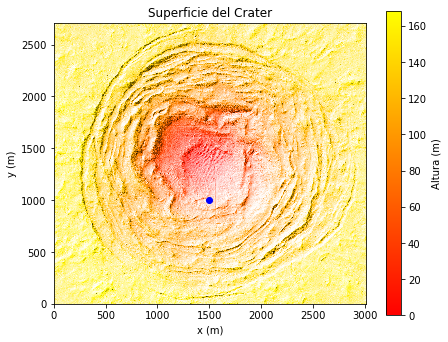

In [22]:
# Estado inicial en formato coordenada x,y.

initial_state = '1500,1000'

row, col = state_to_coordinates(initial_state)
print(row, col)
row, col = coordinates_to_row_column(row, col, n_rows, scale)
print(row, col)
path = []

path.append((None, initial_state)) # Coordenadas del estado inicial

print('Coordenada Inicial:\t', initial_state)
print('Altura del estado inicial: ', image_data[row, col])
plot_crater(path, image_data)

Resultados para la búsqueda codiciosa:
Coordenada Objetivo:	 1214,1698
Altura alcanzada:	 41.88792968750022


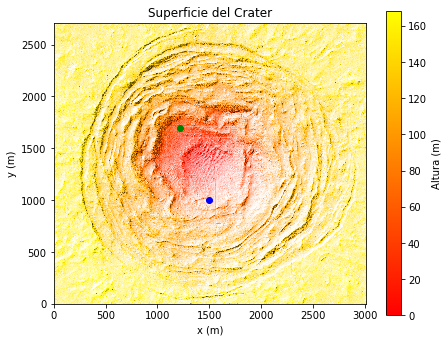

In [23]:
# Creación del objeto problema y la aplicación de la búsqueda codiciosa para resolverlo.
descenso = DescensoCraterMarte(initial_state)
result_hill_climbing = hill_climbing(descenso)

# ### Imprimir el Resultado
path = []
path.append((None, initial_state))
row, col = state_to_coordinates(result_hill_climbing.state)
row, col = coordinates_to_row_column(row, col, n_rows, scale)

print('Resultados para la búsqueda codiciosa:')
print('Coordenada Objetivo:\t', result_hill_climbing.state)
print('Altura alcanzada:\t', image_data[row, col])

result_state = result_hill_climbing.state
path.append([initial_state, result_state])

plot_crater(path, image_data)

In [24]:
print(image_data[1214,1697])

24.98216796875022


In [25]:
# ## Búsqueda con Recocido Simulado
# 
# Dependiendo del protocolo de recocido (`schedule`) y el límite de iteraciones permitidas (`iterations_limit`) se pueden obtener resultados diferentes.
# Por ejemplo:
# 1. Con `schedule=p_schedule` y `iterations_limit=8000`, el algoritmo `simulated_annealing` puede lograr alcanzar un estado objetivo con coordenadas (1519,1355) y una altura de 1.1789453125002183.
# 2. Con `schedule=exp_schedule` y `iterations_limit=8000`, el algoritmo `simulated_annealing` puede lograr alcanzar un estado objetivo con coordenadas (1499,1232) y una altura de 10.488027343750218.
# 
# Los resultados pueden variar, por lo pronto el primer caso parece tener mejor rendimiento.


# Scheduling function
def p_schedule(iteration, alpha = 0.9995):
    
    return 1 * math.pow(alpha, iteration)

def exp_schedule(iteration, k=20, lam=0.005, limit=100):
    '''
    Possible scheduler for simulated_annealing, based on the aima example.
    '''
    return k * math.exp(-lam * iteration)

In [26]:
# Creación del objeto problema y la aplicación de la búsqueda con recocido simulado para resolverlo.  
descenso = DescensoCraterMarte(initial_state)
result_sim_annealing_p = simulated_annealing(descenso, schedule=p_schedule)

result_sim_annealing_exp = simulated_annealing(descenso, schedule=exp_schedule)

Resultados para el Power Schedule:
Coordenada Objetivo:	 1214,1698
Altura alcanzada:	 41.88792968750022

Resultados para el Exp Schedule:
Coordenada Objetivo:	 1216,1697
Altura alcanzada:	 41.49242187500022


<Figure size 432x288 with 0 Axes>

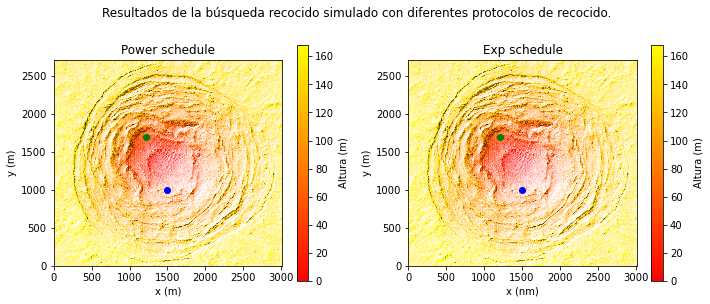

In [27]:
path_p = []
path_p.append((None, initial_state))
path_p.extend(result_sim_annealing_p.path())

path_e = []
path_e.append((None, initial_state))
path_e.extend(result_sim_annealing_exp.path())

row, col = state_to_coordinates(result_sim_annealing_p.state)
row, col = coordinates_to_row_column(row, col, n_rows, scale)

print('Resultados para el Power Schedule:')
print('Coordenada Objetivo:\t', result_sim_annealing_p.state)
print('Altura alcanzada:\t', image_data[row, col])

row, col = state_to_coordinates(result_sim_annealing_exp.state)
row, col = coordinates_to_row_column(row, col, n_rows, scale)

print('\nResultados para el Exp Schedule:')
print('Coordenada Objetivo:\t', result_sim_annealing_exp.state)
print('Altura alcanzada:\t', image_data[row, col])

plot_two_craters(path_p, path_e, image_data)

In [ ]:
"¿Qué algoritmo logra llegar más profundo en el cráter?""
"¿Recomendarían a los ingenieros del robot utilizar alguno de estos algoritmos?"

El algoritmo que nos dio la ruta mas profunda fue el de recocido simulado por lo tanto si recomendamos a los ingenieros que usen
este algortimo ya que nos dio buenos resultados